# 네이버 영화리뷰 감성분석

- 데이터 : [Naver Sentiment Movie corpus](https://github.com/e9t/nsmc)

## 라이브러리 및 데이터 준비

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터 로더 구성
1. 데이터 중복 제거
2. NaN 결측치 제거
3. 한국어 토크나이저로 토큰화
4. 불용어 제거
4. 사전 (word_to_index) 구성
5. 텍스트 스트링을 사전 인덱스 스트링으로 변환
6. X_train, y_train, X_test, y_test, word_to_index 리턴

#### VOCA 생성시, 4개의 빈 공간을 할당하는 이유는 아래와 같다.
- **패딩(padding):** 신경망 모델에서 시퀀스 데이터를 처리할 때 일정한 길이로 만들어주는데, 이를 위해 패딩 토큰이 사용됩니다. \<PAD>

- **미지의 단어(unknown word):** 특정 단어 수를 제한하면서 모든 단어를 다루기 위해, 가장 자주 등장하는 num_words-4개의 단어를 선택하고 나머지는 'unknown'으로 처리할 수 있습니다. \<UNK>

- **시작 토큰(start token):** 문장의 시작을 나타내는 토큰을 추가할 수 있습니다. \<BOS>

- **사용이 된 것에 대한 토큰(unused token):** 임베딩시, 사용되지 않은 단어를 나타냅니다. test 데이터에서 활용합니다. \<UNUSED>

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def data_processing(data, stopwords):
    data_X = []
    
    data.drop_duplicates(subset=['document'], inplace=True)
    data.dropna(how='any', inplace=True)
    
    for sentence in data['document']:
        tmp_X = tokenizer.morphs(sentence) # Tokenizer
        tmp_X = [word for word in tmp_X if word not in stopwords] # rm stopwords
        data_X.append(tmp_X)
    return data_X

def load_data(train_data, test_data, num_words=10000):
    X_train = data_processing(train_data, stopwords)
    X_test = data_processing(test_data, stopwords)
    
    words = np.concatenate(X_train).tolist() # to avoding data leakage
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [4]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

In [7]:
########### 데이터셋 내의 문장 길이 분포 ###########
# 본 코드에서는 Data Leakage를 막기 위해서 Test 데이터를 전처리 시에 활용하지 않습니다.

num_tokens = np.array([len(tokens) for tokens in X_train])

print("문장길이 평균 : ", np.mean(num_tokens))
print("문장길이 최대 : ", np.max(num_tokens))
print("문장길이 표준편차 : ", np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)

print("pad_sequences max len : ", maxlen)
print(f"전체 문장의 {(np.sum(num_tokens < max_tokens) / len(num_tokens))*100:.2f}%가 maxlen 범위 내에 포함된다.")

문장길이 평균 :  15.98170773419436
문장길이 최대 :  116
문장길이 표준편차 :  12.82473766384545
pad_sequences max len :  41
전체 문장의 93.42%가 maxlen 범위 내에 포함된다.


In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train,
                        value=word_to_index["<PAD>"],
                        padding='pre',
                        maxlen=maxlen)

X_test = pad_sequences(X_test,
                       value=word_to_index["<PAD>"],
                       padding='pre',
                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [10]:
vocab_size = 10000
word_vector_dim = 16

## 4. 모델 구성 및 Validation Set 구성

- 본 코드에서는 총 3가지의 모델을 기반으로 성능을 검증해보겠습니다.

### 4-1. Validation Set 구성

In [11]:
val_idx = int(len(X_train)*0.2) # Train Data를 8:2로 validation과 분리하여 준비합니다.

X_val, y_val = X_train[:val_idx], y_train[:val_idx]
X_train, y_train = X_train[val_idx:], y_train[val_idx:]
print(X_train.shape, y_train.shape)

(116946, 41) (116946,)


### 4-1-1. History 시각화 함수

In [12]:
import matplotlib.pyplot as plt

def visualize_history(history):
    history_dict = history.history
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(acc) + 1)  # epochs 변수 정의
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')  # y_label이 아니라 ylabel을 사용
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'ro', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')  # y_label이 아니라 ylabel을 사용
    plt.legend()
    plt.tight_layout()
    plt.show()


### 4-2. LSTM 기반의 간단한 모델

In [13]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=maxlen),
    layers.LSTM(128),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 16)            160000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               74240     
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 235,281
Trainable params: 235,281
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=20

cb_earlystop = EarlyStopping(monitor='val_loss',
                            patience=3,
                            verbose=1,
                            mode='auto',
                            restore_best_weights=True)

history = model.fit(X_train,
                   y_train,
                   batch_size=512,
                   validation_data=(X_val, y_val),
                   verbose=1,
                   epochs=epochs,
                   callbacks=[cb_earlystop])

Epoch 1/20
229/229 [==============================] - 6s 11ms/step - loss: 0.5006 - accuracy: 0.7497 - val_loss: 0.3557 - val_accuracy: 0.8460
Epoch 2/20
229/229 [==============================] - 2s 9ms/step - loss: 0.3409 - accuracy: 0.8551 - val_loss: 0.3463 - val_accuracy: 0.8509
Epoch 3/20
229/229 [==============================] - 2s 9ms/step - loss: 0.3178 - accuracy: 0.8663 - val_loss: 0.3438 - val_accuracy: 0.8529
Epoch 4/20
229/229 [==============================] - 2s 9ms/step - loss: 0.3064 - accuracy: 0.8731 - val_loss: 0.3436 - val_accuracy: 0.8512
Epoch 5/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2948 - accuracy: 0.8788 - val_loss: 0.3482 - val_accuracy: 0.8512
Epoch 6/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2815 - accuracy: 0.8849 - val_loss: 0.3494 - val_accuracy: 0.8528
Epoch 7/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2658 - accuracy: 0.8919 - val_loss: 0.3479 - val_accuracy: 0.8529
Resto

In [15]:
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3547 - accuracy: 0.8455
[0.3547086715698242, 0.8454747200012207]


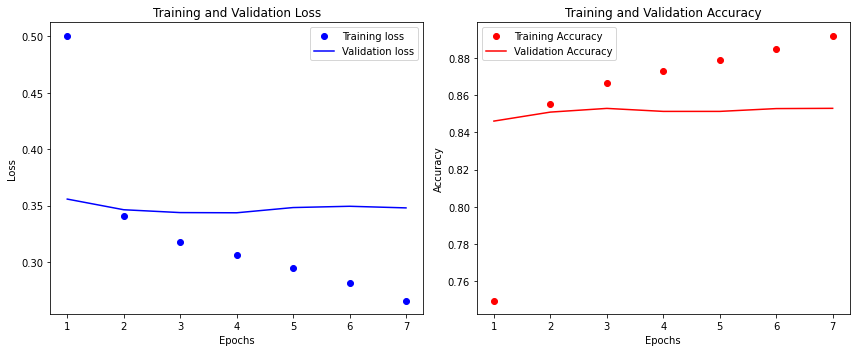

In [16]:
visualize_history(history)

### 4-3. GRU 기반의 간단한 모델

In [40]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=maxlen),
    layers.GRU(256),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 16)            160000    
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               210432    
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 9         
Total params: 372,497
Trainable params: 372,497
Non-trainable params: 0
_________________________________________________________________


In [41]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=20

cb_earlystop = EarlyStopping(monitor='val_loss',
                            patience=5,
                            verbose=1,
                            mode='auto',
                            restore_best_weights=True)

history = model.fit(X_train,
                   y_train,
                   batch_size=512,
                   validation_data=(X_val, y_val),
                   verbose=1,
                   epochs=epochs,
                   callbacks=[cb_earlystop])

Epoch 1/20
229/229 [==============================] - 6s 19ms/step - loss: 0.4541 - accuracy: 0.7787 - val_loss: 0.3518 - val_accuracy: 0.8485
Epoch 2/20
229/229 [==============================] - 4s 17ms/step - loss: 0.3363 - accuracy: 0.8575 - val_loss: 0.3549 - val_accuracy: 0.8479
Epoch 3/20
229/229 [==============================] - 4s 17ms/step - loss: 0.3193 - accuracy: 0.8661 - val_loss: 0.3463 - val_accuracy: 0.8515
Epoch 4/20
229/229 [==============================] - 4s 17ms/step - loss: 0.3067 - accuracy: 0.8731 - val_loss: 0.3467 - val_accuracy: 0.8489
Epoch 5/20
229/229 [==============================] - 4s 18ms/step - loss: 0.2899 - accuracy: 0.8814 - val_loss: 0.3363 - val_accuracy: 0.8576
Epoch 6/20
229/229 [==============================] - 4s 18ms/step - loss: 0.2695 - accuracy: 0.8904 - val_loss: 0.3316 - val_accuracy: 0.8598
Epoch 7/20
229/229 [==============================] - 4s 18ms/step - loss: 0.2491 - accuracy: 0.9000 - val_loss: 0.3423 - val_accuracy: 0.8558

In [44]:
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3433 - accuracy: 0.8522
[0.34333908557891846, 0.8522489070892334]


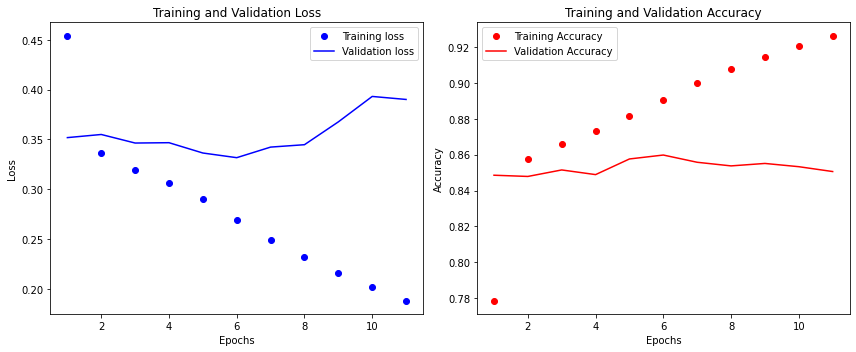

In [43]:
visualize_history(history)

### 4-4. 간단한 Transformer 모델

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 하이퍼파라미터 설정
vocab_size = 10000  # 사용할 어휘 사전 크기
embedding_dim = 16  # 임베딩 차원
num_heads = 5  # 어텐션 헤드 수
ff_dim = 128  # 피드포워드 네트워크의 차원

# 입력 레이어
inputs = Input(shape=(maxlen,))

# 임베딩 레이어
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)

# 포지셔널 인코딩
positional_encoding = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embedding_dim)(tf.range(start=0, limit=maxlen, delta=1))
inputs_with_position = embedding_layer + positional_encoding

In [33]:
# 쿼리, 키, 밸류 생성
query = inputs_with_position
key = inputs_with_position
value = inputs_with_position

# 어텐션 연산
attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads)(query, key, value)

# 피드포워드 네트워크
ffn_output = tf.keras.layers.Dense(ff_dim, activation='relu')(attention_output)
ffn_output = tf.keras.layers.Dense(embedding_dim)(ffn_output)

# 잔차 연결 및 정규화
outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs_with_position + ffn_output)

# 글로벌 평균 풀링 레이어
outputs = GlobalAveragePooling1D()(outputs)

# 출력 레이어
outputs = Dense(1, activation='sigmoid')(outputs)

# 모델 생성
model = Model(inputs=inputs, outputs=outputs)

In [45]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, 
                    y_train, 
                    epochs=10, 
                    batch_size=512, 
                    validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
229/229 [==============================] - 6s 19ms/step - loss: 0.2510 - accuracy: 0.8986 - val_loss: 0.3446 - val_accuracy: 0.8578
Epoch 2/10
229/229 [==============================] - 4s 18ms/step - loss: 0.2330 - accuracy: 0.9069 - val_loss: 0.3534 - val_accuracy: 0.8530
Epoch 3/10
229/229 [==============================] - 4s 18ms/step - loss: 0.2176 - accuracy: 0.9131 - val_loss: 0.3723 - val_accuracy: 0.8529
Epoch 4/10
229/229 [==============================] - 4s 18ms/step - loss: 0.2016 - accuracy: 0.9200 - val_loss: 0.3923 - val_accuracy: 0.8522


In [46]:
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3993 - accuracy: 0.8472
[0.39932262897491455, 0.847163200378418]


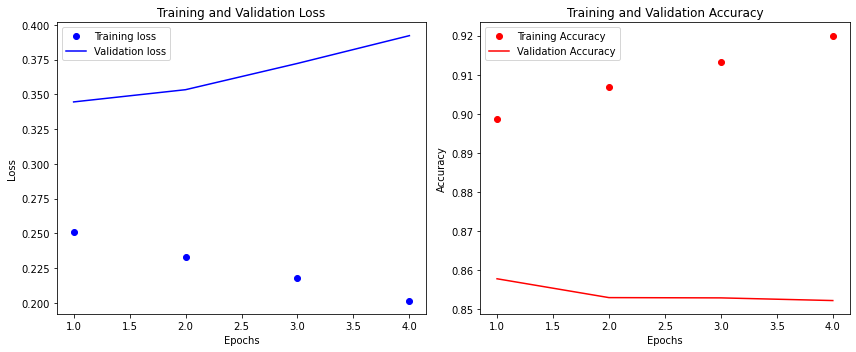

In [47]:
visualize_history(history)

## 7. 학습된 Embedding 레이어 분석

In [50]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [71]:
ko_word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ko.txt'

with open(ko_word2vec_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) # 몇 개의 벡터를 얼마 사이즈로 기재할지 타이틀 작성
    vectors = model.get_weights()[0]
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()

In [72]:
my_word_vectors = Word2VecKeyedVectors.load_word2vec_format(ko_word2vec_path, binary=False)
vector = my_word_vectors['아니']
vector

array([ 0.04047423, -0.0502904 , -0.06203404, -0.09566802,  0.04674076,
       -0.05586057, -0.03626178, -0.09971483, -0.10606192,  0.06770135,
       -0.08228029, -0.01652914, -0.00018549,  0.05778557, -0.06327622,
        0.08228981], dtype=float32)

In [76]:
my_word_vectors.similar_by_word("아니")

[('↓', 0.9266678094863892),
 ('워커', 0.8938032984733582),
 ('않', 0.8858081698417664),
 ('아님', 0.8828611373901367),
 ('바디', 0.8784153461456299),
 ('만난', 0.8738514184951782),
 ('깨달', 0.8729018568992615),
 ('놈', 0.8688187599182129),
 ('."', 0.8652902841567993),
 ('천만', 0.8625597953796387)]

## 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [79]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME') + '/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['아니']
vector

array([-0.54114103, -1.5807747 , -0.7396592 , -0.04391506, -1.469551  ,
       -3.5018036 ,  2.843011  , -3.90837   , -1.1900015 ,  4.9123926 ,
        1.1276851 ,  0.7632711 , -2.8278723 ,  2.2330832 , -1.373043  ,
       -1.6724821 , -1.4934297 ,  4.4470654 , -3.4066153 , -3.311651  ,
        0.5878737 ,  1.6913736 ,  0.55354494,  1.4497492 ,  5.0122495 ,
       -4.7105107 ,  3.5322056 ,  1.8614265 ,  4.1252775 ,  4.9718575 ,
       -1.271035  ,  2.3811085 , -2.373051  , -0.69244426,  0.83564675,
        1.0541602 , -3.673553  , -4.865206  , -1.7825997 ,  0.6724924 ,
        1.4352766 ,  4.628694  ,  0.23677126,  0.27020186, -1.8919611 ,
       -4.883834  ,  2.6137884 , -7.813117  ,  0.36240625,  6.0204506 ,
        0.8698564 ,  1.2134596 ,  8.060942  , -0.7649789 ,  2.3344295 ,
       -0.593702  ,  1.1262753 ,  1.9215059 ,  1.0554444 , -0.08336125,
        1.7698146 ,  4.826664  , -0.00968416, -5.058337  ,  3.03791   ,
       -0.53616285, -1.4947625 , -0.2932168 , -4.003369  , -2.67

In [78]:
word_vectors.wv.similar_by_word('아니')

[('오로지', 0.6562415361404419),
 ('오직', 0.629123330116272),
 ('믿', 0.5989415645599365),
 ('순전히', 0.5725270509719849),
 ('없', 0.5699899196624756),
 ('할지라도', 0.565227210521698),
 ('단순히', 0.5642708539962769),
 ('물론', 0.5641003847122192),
 ('불리', 0.5548262596130371),
 ('아닌', 0.5507720112800598)]

In [88]:
import os
import numpy as np
from gensim.models import KeyedVectors

# Word2Vec 모델 로드
word2vec_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 임베딩 행렬 생성 및 초기화
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피합니다.
for i in range(4, vocab_size):
    word = index_to_word[i]  # index_to_word는 이전에 만들어둔 인덱스를 단어로 바꾸는 딕셔너리입니다.
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

In [89]:
import tensorflow as tf
from tensorflow.keras.initializers import Constant

# 모델 구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 
                              word_vector_dim, 
                              embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                              input_length=maxlen, 
                              trainable=True),  # trainable을 True로 주면 Fine-tuning
    tf.keras.layers.Conv1D(16, 7, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Conv1D(16, 7, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 41, 300)           3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                

In [94]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[EarlyStopping(patience=3)],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 9ms/step - loss: 0.0652 - accuracy: 0.9808 - val_loss: 0.6744 - val_accuracy: 0.8243
Epoch 2/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0522 - accuracy: 0.9854 - val_loss: 0.6766 - val_accuracy: 0.8223
Epoch 3/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0487 - accuracy: 0.9863 - val_loss: 0.7731 - val_accuracy: 0.8196
Epoch 4/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0470 - accuracy: 0.9861 - val_loss: 0.7647 - val_accuracy: 0.8206


In [95]:
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8018 - accuracy: 0.8146
[0.8018139600753784, 0.8145737051963806]


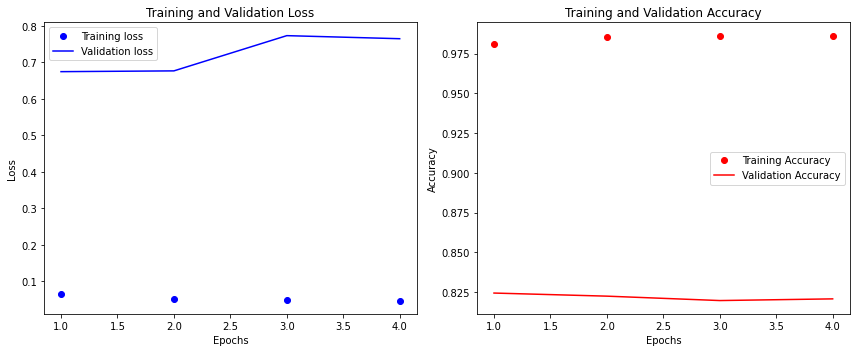

In [96]:
visualize_history(history)

- 1-D Convoltion을 사용해서 성능이 더욱 떨어진 것으로 보인다.
- 따라서, 이전에 가장 좋은 성능을 보여준 GRU 모델과 Transformer 모델을 바탕으로 이를 수정해서 진행해보겠습니다.

### 8-1. GRU 모델을 바탕으로 학습 수행

In [97]:
model = models.Sequential([
    layers.Embedding(vocab_size, 
                  word_vector_dim, 
                  embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                  input_length=maxlen, 
                  trainable=True),  # trainable을 True로 주면 Fine-tuning,
    layers.GRU(256),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 41, 300)           3000000   
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               428544    
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 9         
Total params: 3,430,609
Trainable params: 3,430,609
Non-trainable params: 0
_________________________________________________________________


In [98]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[EarlyStopping(patience=3)],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 8s 28ms/step - loss: 0.5725 - accuracy: 0.6747 - val_loss: 0.3763 - val_accuracy: 0.8351
Epoch 2/20
229/229 [==============================] - 6s 27ms/step - loss: 0.3454 - accuracy: 0.8508 - val_loss: 0.3271 - val_accuracy: 0.8583
Epoch 3/20
229/229 [==============================] - 6s 27ms/step - loss: 0.2995 - accuracy: 0.8742 - val_loss: 0.3147 - val_accuracy: 0.8638
Epoch 4/20
229/229 [==============================] - 6s 27ms/step - loss: 0.2718 - accuracy: 0.8879 - val_loss: 0.3595 - val_accuracy: 0.8485
Epoch 5/20
229/229 [==============================] - 6s 28ms/step - loss: 0.2508 - accuracy: 0.8982 - val_loss: 0.3309 - val_accuracy: 0.8635
Epoch 6/20
229/229 [==============================] - 6s 28ms/step - loss: 0.2270 - accuracy: 0.9109 - val_loss: 0.3277 - val_accuracy: 0.8631


In [99]:
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3358 - accuracy: 0.8584
[0.3358425796031952, 0.858372151851654]


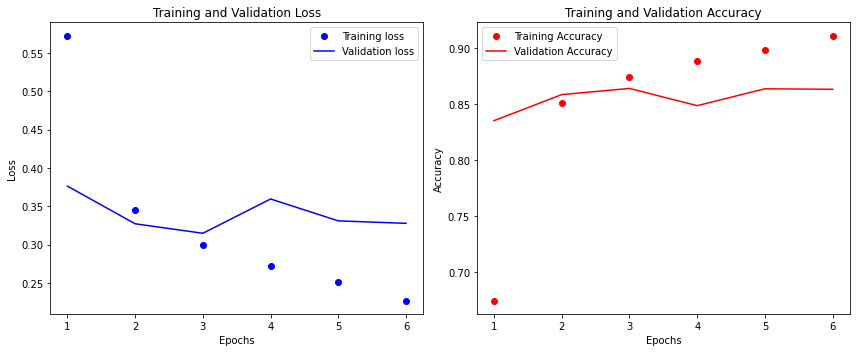

In [100]:
visualize_history(history)

### 8-2. Transformer 모델을 바탕으로 학습

In [103]:
# 하이퍼파라미터 설정
vocab_size = 10000  # 사용할 어휘 사전 크기
embedding_dim = 300  # 임베딩 차원
num_heads = 5  # 어텐션 헤드 수
ff_dim = 128  # 피드포워드 네트워크의 차원

# 입력 레이어
inputs = Input(shape=(maxlen,))

# 임베딩 레이어
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)

# 포지셔널 인코딩
positional_encoding = layers.Embedding(vocab_size, 
                      word_vector_dim, 
                      embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                      input_length=maxlen, 
                      trainable=True)(tf.range(start=0, limit=maxlen, delta=1))
inputs_with_position = embedding_layer + positional_encoding

In [105]:
# 쿼리, 키, 밸류 생성
query = inputs_with_position
key = inputs_with_position
value = inputs_with_position

# 어텐션 연산
attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads)(query, key, value)

# 피드포워드 네트워크
ffn_output = tf.keras.layers.Dense(ff_dim, activation='relu')(attention_output)
ffn_output = tf.keras.layers.Dense(embedding_dim)(ffn_output)

# 잔차 연결 및 정규화
outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs_with_position + ffn_output)

# 글로벌 평균 풀링 레이어
outputs = GlobalAveragePooling1D()(outputs)

# 출력 레이어
outputs = Dense(1, activation='sigmoid')(outputs)

# 모델 생성
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 41, 300)      3000000     input_6[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add_7 (TFOpLam (None, 41, 300)      0           embedding_18[0][0]               
__________________________________________________________________________________________________
multi_head_attention_4 (MultiHe (None, 41, 300)      361200      tf.__operators__.add_7[0][0]     
                                                                 tf.__operators__.add_7[0][0

In [106]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[EarlyStopping(patience=3)],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 10s 42ms/step - loss: 0.5903 - accuracy: 0.7363 - val_loss: 0.4850 - val_accuracy: 0.8164
Epoch 2/20
229/229 [==============================] - 10s 42ms/step - loss: 0.4064 - accuracy: 0.8234 - val_loss: 0.4123 - val_accuracy: 0.8191
Epoch 3/20
229/229 [==============================] - 10s 42ms/step - loss: 0.3438 - accuracy: 0.8522 - val_loss: 0.3441 - val_accuracy: 0.8511
Epoch 4/20
229/229 [==============================] - 10s 42ms/step - loss: 0.3207 - accuracy: 0.8642 - val_loss: 0.3400 - val_accuracy: 0.8534
Epoch 5/20
229/229 [==============================] - 10s 43ms/step - loss: 0.3068 - accuracy: 0.8712 - val_loss: 0.3483 - val_accuracy: 0.8491
Epoch 6/20
229/229 [==============================] - 10s 43ms/step - loss: 0.2946 - accuracy: 0.8771 - val_loss: 0.3513 - val_accuracy: 0.8488
Epoch 7/20
229/229 [==============================] - 10s 43ms/step - loss: 0.2840 - accuracy: 0.8827 - val_loss: 0.3566 - val_accuracy:

In [107]:
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3703 - accuracy: 0.8403
[0.37030789256095886, 0.8403279185295105]


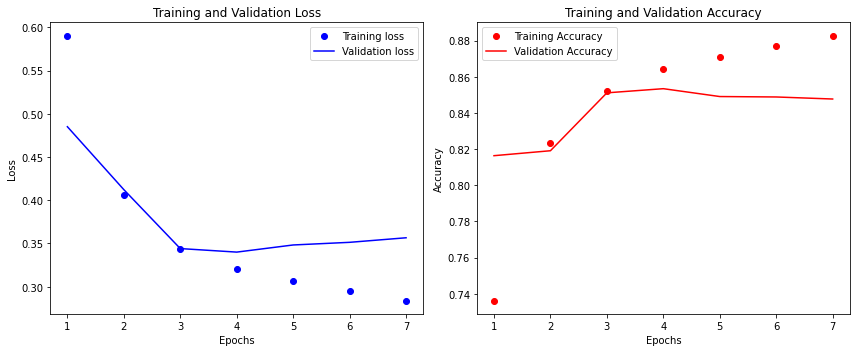

In [108]:
visualize_history(history)

- GRU의 경우 0.8522 -> 0.8584으로 소폭 성능이 상승하는 모습을 보여줬다.
- Transfomer의 경우 0.8472 -> 0.8403으로 소폭 성능 하락하는 모습을 보여줬다.

- 자세한 원인을 알 수는 없었으나, 모델의 복잡도와 파라미터 수에 따라 더욱 복잡한 임베딩 벡터를 넣으면 그에 맞게 영향을 받는 것으로 보인다.
- 이 부분은 조금 더 확인해봐야 알 수 있을 것 같다.
- 또한 대부분 모델 자체적으로 과적합되는 모습을 보여줬다.
- 이 부분도 데이터의 복잡도에 큰 영향을 받은 것으로 판단된다.
- 따라서 임베딩 벡터의 차원 수를 낮추는 방향으로 모델 학습을 진행하면 더욱 향상된 모델 성능을 얻을 수 있을 것이라고 판단된다.